<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025-2/blob/main/DL_day8/8_1_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

In [1]:
import os, csv, json, unicodedata
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image #resize
from torchvision.transforms import functional as TF

import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# 디바이스 - CTC Loss는 CPU로 계산 예정
device = torch.device(
    "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else "cpu"
)
print("device:", device)

device: mps


## Load data

In [6]:
CSV_TRAIN = "../text_crops/train_labels.csv" #라벨
CSV_VAL   = "../text_crops/valid_labels.csv" #라벨
CHARSET_JSON  = "../charset.json" #vacab

In [7]:
# CNN 입력 설정
IMG_H   = 28     # 이미지 세로 길이 고정
IN_CH   = 1      # 입력 채널 수 (흑백=1)
PATCH_W = 28     # 패치 너비
STRIDE  = 14     # 슬라이딩 보폭(겹침 제어)

# 학습 설정
BATCH   = 32
LR      = 0.001 #learning rate
EPOCHS  = 20


class Charset 설정 - vocab 파일 내 텍스트와 정수 인덱스 상호 변환

In [8]:
class Charset:
    def __init__(self, itos, blank_idx=0):
        self.itos = itos # index to string
        self.blank_idx = blank_idx # CTC blank index
        self.stoi = {ch:i for i,ch in enumerate(itos)} # string to index

    @classmethod
    def from_json(cls, path):
        with open(path, "r", encoding="utf-8") as f:
            chars = json.load(f)
        itos = ["<blank>"] + chars
        return cls(itos, blank_idx=0)

    def encode(self, s):
        return [self.stoi[ch] for ch in s]

charset = Charset.from_json(CHARSET_JSON)
VOCAB_SIZE = len(charset.itos)
print("blank_idx:", charset.blank_idx, "vocab_size:", VOCAB_SIZE)

blank_idx: 0 vocab_size: 731


라벨 데이터(.csv) 내용
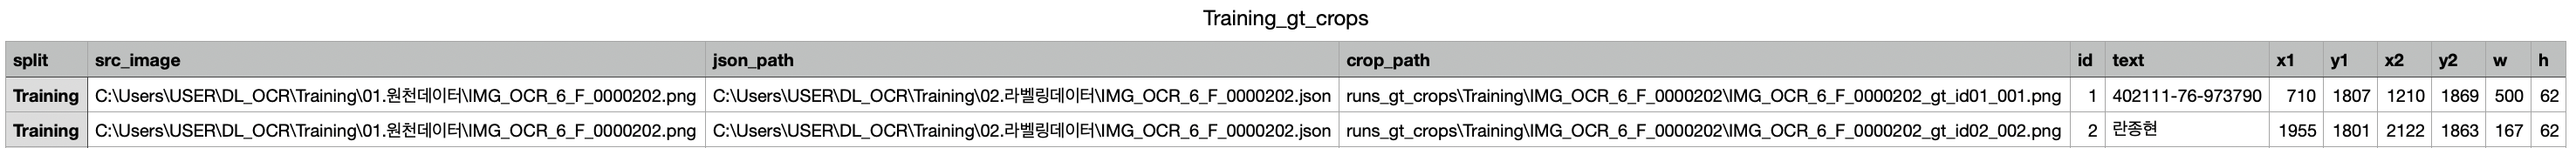

resolve_path() : CSV의 상대경로를 절대경로로 변환

read_rows() : CSV를 읽음(crop_path, text) -- 파일경로가 존재하면 row 리스트에 추가

In [9]:
DATA_ROOT = "../text_crops"

def resolve_path(p: str) -> str:
    p = p[32:]
    p = p.strip().replace("\\", "/")
    return os.path.normpath(os.path.join(DATA_ROOT, p))

def read_rows(csv_path, path_key="crop_path", text_key="text"):
    rows = []
    with open(csv_path, "r", encoding="utf-8") as f:
        r = csv.DictReader(f)
        for row in r:
            p = resolve_path(row.get(path_key))
            t = row.get(text_key)
            rows.append({"crop_path": p, "text": t})
    print(f"[{csv_path}] loaded {len(rows)} rows")
    return rows


class Resize : 이미지 세로길이 통일(resizing), 원본 비율은 유지

class OCRDataset : PyTorch Dataset 커스텀 - 한 샘플은 '이미지텐서 & 정답 인덱스 시퀀스'를 돌려줌

ctc_collate

In [10]:
class Resize:
    def __init__(self, h:int): self.h = h
    def __call__(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        new_w = max(1,int(w * (self.h / float(h))))
        return img.resize((new_w, self.h), Image.BILINEAR) #보간 - 주변 픽셀 4개의 가중평균 (cf. Bicubic - 16개)
    

class OCRDataset(Dataset):
    """CSV(crop_path,text) → (tensor[C,H,W], target[int-seq])"""
    def __init__(self, csv_path: str, charset: Charset, target_h: int = IMG_H, path_key="crop_path"):
        self.rows = read_rows(csv_path, path_key=path_key, text_key="text")
        self.cs = charset
        self.norm = "NFC"
        self.resize = Resize(target_h)

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        r = self.rows[i]
        
        img = Image.open(r["crop_path"]).convert("L")  # 흑백
        img = self.resize(img)
        x = TF.to_tensor(img) # 이미지를 텐서로 변환 [1,H,W]
        
        txt = unicodedata.normalize(self.norm, r["text"])
        txt = "".join(ch for ch in txt if ch in self.cs.stoi)  #문자셋에 없는 글자(OOV)는 무시
        y = torch.tensor(self.cs.encode(txt), dtype=torch.long) #문자열 → 정수 인덱스 시퀀스
        
        return x, y

def ctc_collate(batch):
    xs, ys = zip(*batch)        # xs: [B][C,H,W], ys: [B][L]
    C, H = xs[0].shape[:2]      #전처리 완료한 상태 - 첫번쨰 샘플 값 가져옴
    max_W = max(x.shape[2] for x in xs) #배치 내 최대 너비
     #패딩: 너비가 다른 이미지들을 오른쪽을 0으로 채워 맞춤
    xs_pad = [F.pad(x, (0, max_W - x.shape[2], 0, 0)) for x in xs]
    xs = torch.stack(xs_pad, 0) # [B,C,H,max_W]
    y_lens = torch.tensor([y.numel() for y in ys], dtype=torch.long) # [B] - 각 시퀀스 길이
    ys = torch.cat(ys, 0)       # [sum(L)] - 시퀀스들을 하나로 연결 - CTC Loss용
    return xs, ys, y_lens


In [11]:
class SlidingCTC(nn.Module):
    def __init__(self, base_cnn: nn.Module, vocab_size: int,
                 patch_w: int = PATCH_W, stride: int = STRIDE,
                 input_h: int = IMG_H, in_ch: int = IN_CH):
        super().__init__()
        self.cnn = base_cnn
        self.patch_w = patch_w
        self.stride  = stride
        self.input_h = input_h
        self.in_ch   = in_ch
        self.map = nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        patches = F.unfold(x, kernel_size=(H, self.patch_w), stride=(H, self.stride))
        L = patches.shape[-1]  # 슬라이딩 횟수
        patches = patches.transpose(1, 2).contiguous().view(B * L, C, H, self.patch_w)
        feats = self.cnn(patches)         # [B*L, ...]
        feats = feats.view(feats.size(0), -1)
        logits = self.map(feats)          # [B*L, V]
        logits = logits.view(B, L, -1).transpose(0, 1).contiguous()  # [T=L, B, V]
        return logits, L


In [12]:
train_set = OCRDataset(CSV_TRAIN, charset, target_h=IMG_H, path_key="crop_path")
val_set   = OCRDataset(CSV_VAL,   charset, target_h=IMG_H, path_key="crop_path")

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  collate_fn=ctc_collate)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, collate_fn=ctc_collate)

# 샘플 배치 확인
xb, yb, ylen = next(iter(train_loader))
print("sample batch:", xb.shape, yb.shape, ylen.shape)


[../text_crops/train_labels.csv] loaded 132754 rows
[../text_crops/valid_labels.csv] loaded 17145 rows
sample batch: torch.Size([32, 1, 28, 203]) torch.Size([169]) torch.Size([32])


## 모델 정의
Backbone : CNN

시퀀스 구성 : Sliding CTC -- 단순하고 빠름, 문자를 분리할 필요가 없음

손실함수 : CTC Loss -- 가변길이 시퀀스에 적합

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            # 블럭1
            nn.Conv2d(1, 32, 3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            
            # 블럭2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.15),
            
            # 블럭3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
        )
        
        # 합성곱 레이어 이후 feature 크기 계산
        # IMG_H=28: 28->14->7->3
        feature_size = 128 * 3 * 3
        
        self.fc_layer = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, vocab_size)  # 보캡 사이즈로 분류
        )

    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out

In [14]:
base_cnn = CNN(VOCAB_SIZE)
model = SlidingCTC(base_cnn, vocab_size=VOCAB_SIZE,
                   patch_w=PATCH_W, stride=STRIDE, 
                   input_h=IMG_H, in_ch=IN_CH).to(device)

criterion = nn.CTCLoss(blank=charset.blank_idx, zero_infinity=True)
opt = torch.optim.Adam(model.parameters(), lr=LR) #Adam 옵티마이저 사용

## 학습

성능지표 : CER

greedy_decode : CER 계산을 위해 필요

* Greedy 방식 - 매 타임스텝마다 argmax만 취함 -- 단순하고 빠름

* Beam Search 방식 - 여러 후보를 확률로 추적 -- 정확하고 맥락 반영

* 제한된 리소스 하에서 Greedy 방식 채택

In [16]:
# 성능지표 : CER
def cer(ref: str, hyp: str) -> float:
    import editdistance
    if len(ref) == 0:
        return 0.0 if len(hyp) == 0 else 1.0
    return editdistance.eval(ref, hyp) / len(ref)

# 성능평가를 위한 디코더
def greedy_decode(logits, charset):

    idx = logits.argmax(2)  # [T,B]
    T, B = idx.shape
    texts = []
    for b in range(B):
        prev = -1
        seq=[]
        for t in range(T):
            p = int(idx[t,b])
            if p != charset.blank_idx and p != prev:
                seq.append(charset.itos[p])
            prev = p
        texts.append("".join(seq))
    return texts

# 성능지표 계산
def evaluate_cer(model, val_loader, charset, device):
    model.eval()
    total_cer, n = 0.0, 0
    with torch.no_grad():
        for xs, ys, y_lens in val_loader:
            xs = xs.to(device)
            logits, _ = model(xs)

            # 예측
            preds = greedy_decode(logits, charset)

            # 정답 복원
            gts = []
            off = 0
            for L in y_lens.tolist():
                gts.append("".join(charset.itos[i] for i in ys[off:off+L].tolist()))
                off += L

            # CER 계산
            for gt, pr in zip(gts, preds):
                total_cer += cer(gt, pr)
                n += 1

    return total_cer / n if n > 0 else 1.0



In [ ]:
best_cer = float("inf")
save_path = os.path.join("..", "best_model_cnn.pth")

for epoch in range(EPOCHS):
    model.train()
    for i, (xs, ys, y_lens) in enumerate(train_loader, start=1):
        xs, ys = xs.to(device), ys.to(device)
        logits, T = model(xs)                 # logits: [T,B,V]
        logp = F.log_softmax(logits, dim=2)
        x_lens = torch.full((logp.shape[1],), T, dtype=torch.long, device=logp.device)

        # CTC Loss (MPS 미지원 → CPU 계산)
        loss = criterion(logp.cpu(), ys.cpu(), x_lens.cpu(), y_lens.cpu())

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Iter 단위 학습 Loss 출력
        if i % 100 == 0 or i == len(train_loader):
            print(f"Epoch {epoch+1}/{EPOCHS} | Iter {i}/{len(train_loader)} | Train Loss {loss.item():.4f}")

    # Epoch 종료 후 Validation CER
    val_cer = evaluate_cer(model, val_loader, charset, device)
    print(f"Epoch {epoch+1}/{EPOCHS} | Validation CER: {val_cer:.4f}")

    # Best 모델 저장
    if val_cer < best_cer:
        best_cer = val_cer
        torch.save(model.state_dict(), save_path)
        print(f" Best model 저장 (CER={val_cer:.4f}) at {save_path}")

Epoch 1/20 | Iter 100/4149 | Train Loss 0.7026
Epoch 1/20 | Iter 200/4149 | Train Loss 0.5266
Epoch 1/20 | Iter 300/4149 | Train Loss 1.1406
Epoch 1/20 | Iter 400/4149 | Train Loss 0.5823
Epoch 1/20 | Iter 500/4149 | Train Loss 1.0088
Epoch 1/20 | Iter 600/4149 | Train Loss 1.3786
Epoch 1/20 | Iter 700/4149 | Train Loss 1.0734
Epoch 1/20 | Iter 800/4149 | Train Loss 0.9186
Epoch 1/20 | Iter 900/4149 | Train Loss 0.8418
Epoch 1/20 | Iter 1000/4149 | Train Loss 0.8406
Epoch 1/20 | Iter 1100/4149 | Train Loss 0.9956
Epoch 1/20 | Iter 1200/4149 | Train Loss 0.5697
Epoch 1/20 | Iter 1300/4149 | Train Loss 1.1173
Epoch 1/20 | Iter 1400/4149 | Train Loss 0.8002
Epoch 1/20 | Iter 1500/4149 | Train Loss 0.9434
Epoch 1/20 | Iter 1600/4149 | Train Loss 0.6673
Epoch 1/20 | Iter 1700/4149 | Train Loss 0.8543
Epoch 1/20 | Iter 1800/4149 | Train Loss 0.7456
Epoch 1/20 | Iter 1900/4149 | Train Loss 0.9372
Epoch 1/20 | Iter 2000/4149 | Train Loss 0.5572
Epoch 1/20 | Iter 2100/4149 | Train Loss 0.7520
E

## 결과확인(샘플 이미지)

In [21]:
#샘플 미리보기
@torch.no_grad()
def preview_samples(model, loader, charset, n):
    model.eval()

    # 한 배치 꺼내기
    xs, ys, y_lens = next(iter(loader))
    xs = xs.to(device)

    # 예측
    logits, _ = model(xs)
    preds = greedy_decode(logits, charset)

    # 정답 복원
    gts = []
    off = 0
    for L in y_lens.tolist():
        gts.append("".join(charset.itos[i] for i in ys[off:off+L].tolist()))
        off += L

    # 콘솔 출력
    print(f"샘플 {n}개 예측 결과:")
    for i in range(min(n, len(preds))):
        mark = "✓" if preds[i] == gts[i] else "✗"
        print(f"[{i}] GT: {gts[i]} | PR: {preds[i]} {mark}")

    # 이미지 시각화
    plt.figure(figsize=(15, 3))
    for i in range(min(n, len(preds))):
        ax = plt.subplot(1, n, i+1)
        img = xs[i].cpu()
        if img.shape[0] == 1:  # 흑백
            ax.imshow(img.squeeze(0), cmap='gray')
        else:  # 컬러
            ax.imshow(img.permute(1, 2, 0))
        ax.set_title(f"PR:{preds[i]}\nGT:{gts[i]}",
                     fontsize=9,
                     color="green" if preds[i]==gts[i] else "red")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# 한글 폰트 설정 - 글자 깨짐 방지
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

샘플 10개 예측 결과:
[0] GT: 474387-05-714500 | PR: 474387-05-1450 ✗
[1] GT: 탕시우 | PR: 탕시지우 ✗
[2] GT: 부산광역시 | PR: 부산광역시 ✓
[3] GT: 사상구 | PR: 사상구 ✓
[4] GT: 임하면 | PR: 임하면 ✓
[5] GT: 217 | PR: 217 ✓
[6] GT: 전라북도 | PR: 전라북도 ✓
[7] GT: 서초구 | PR: 서초구 ✓
[8] GT: 애상로 | PR: 애상로 ✓
[9] GT: 886 | PR: 860 ✗


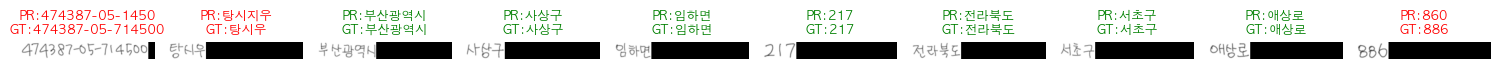

In [22]:
preview_samples(model, val_loader, charset, n=10)
